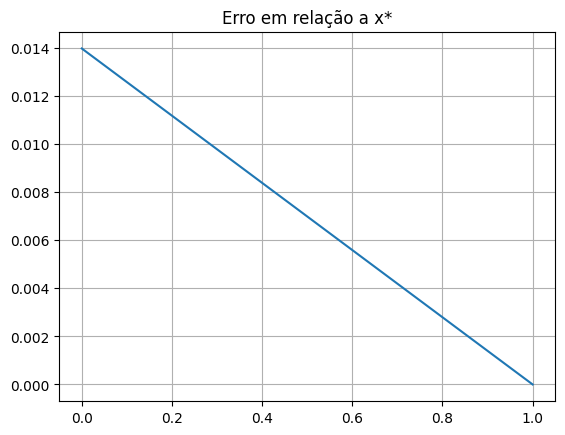

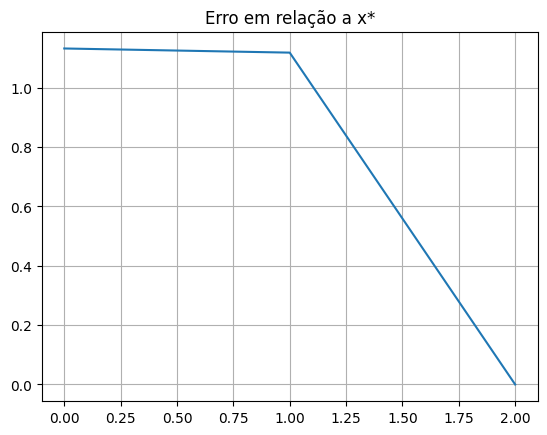

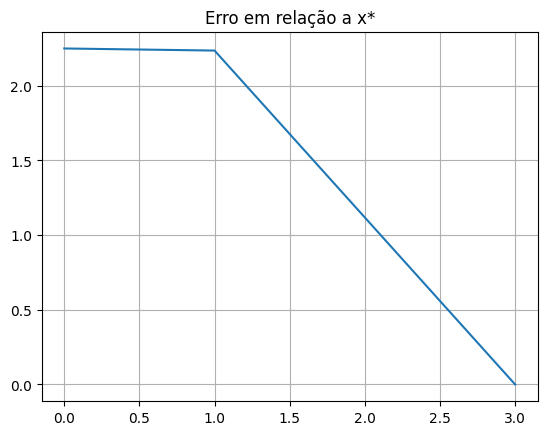

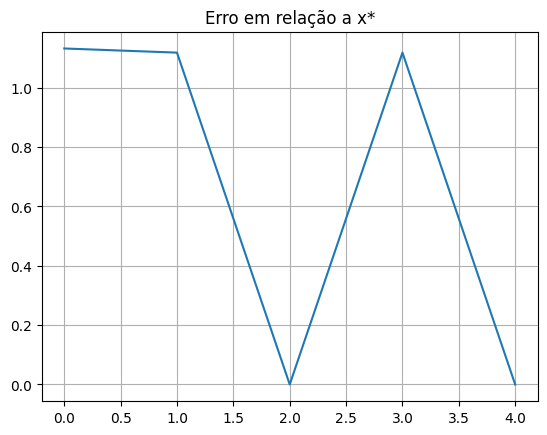

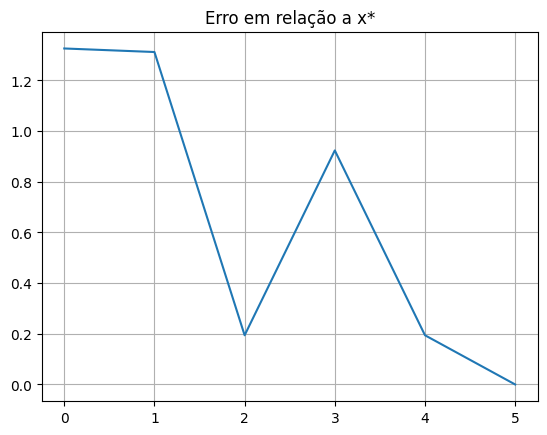

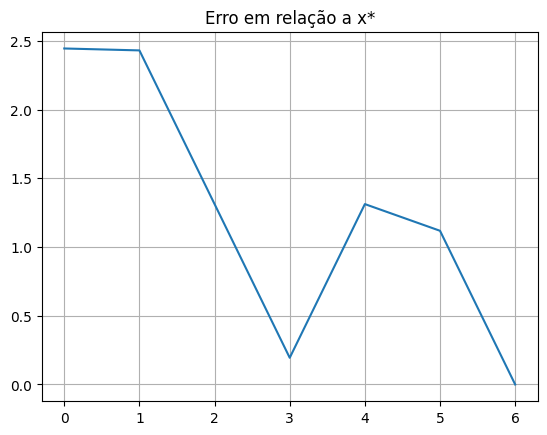

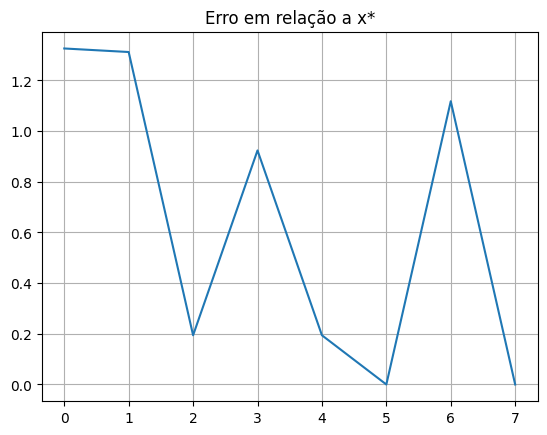

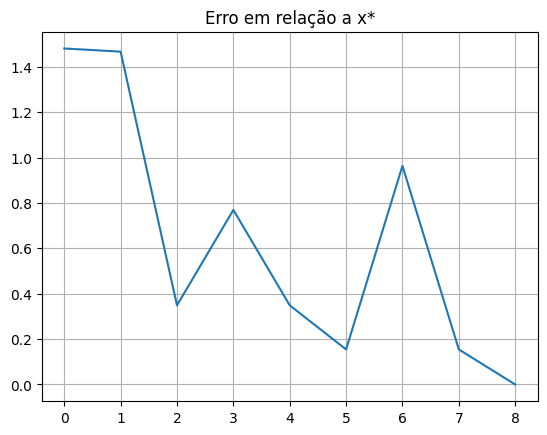

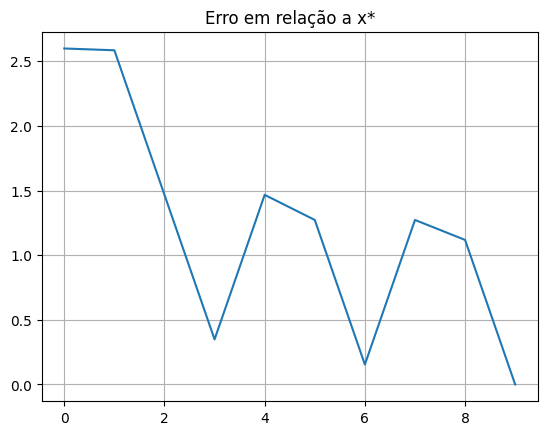

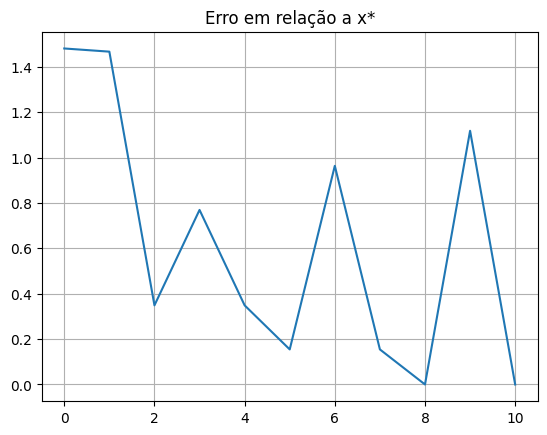

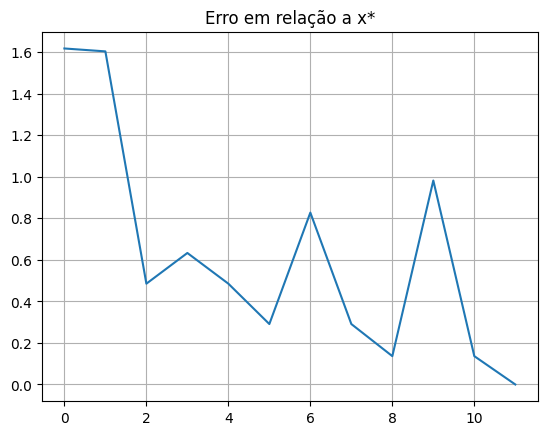

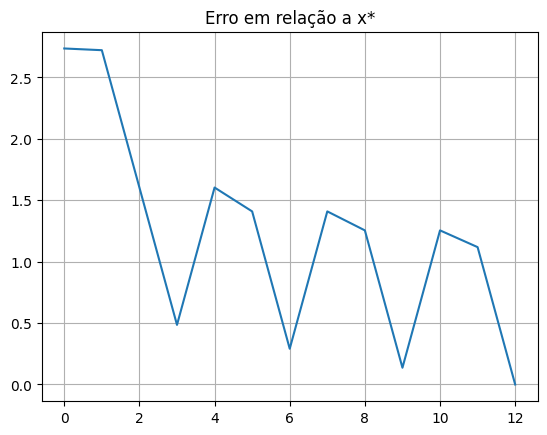

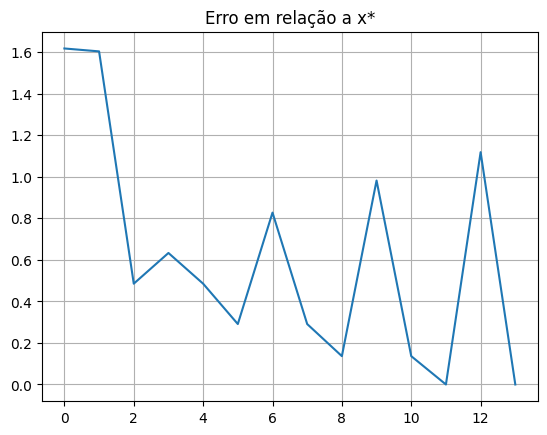

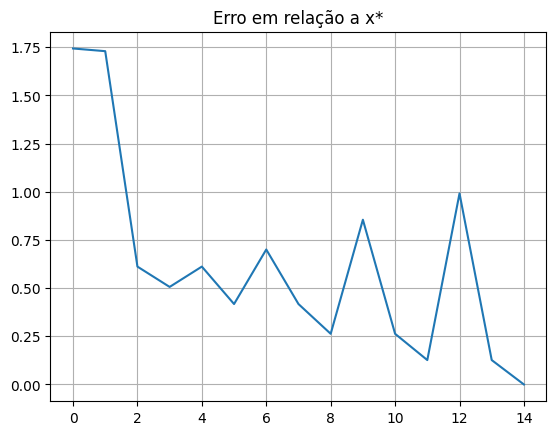

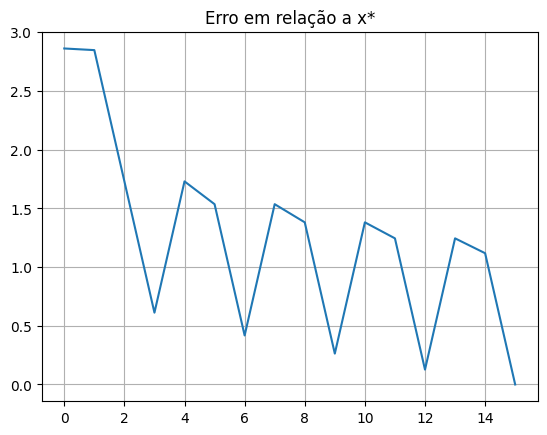

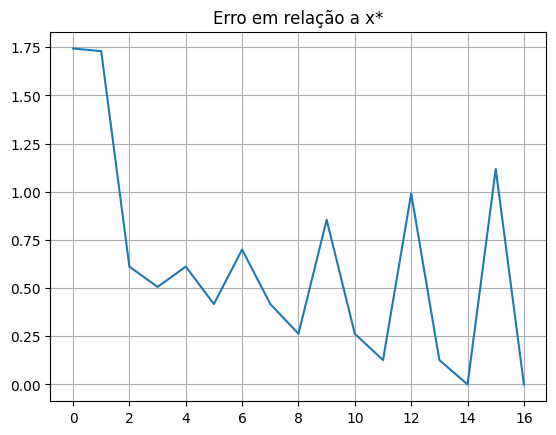

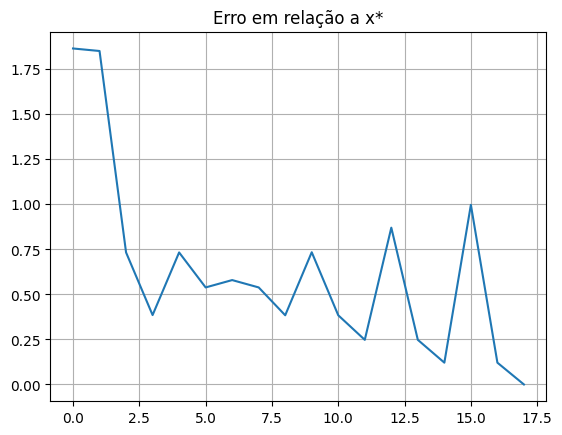

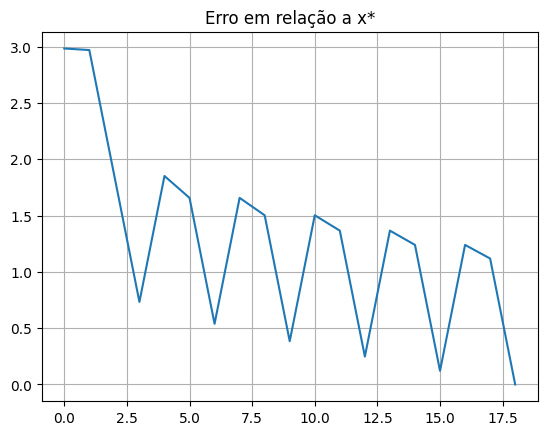

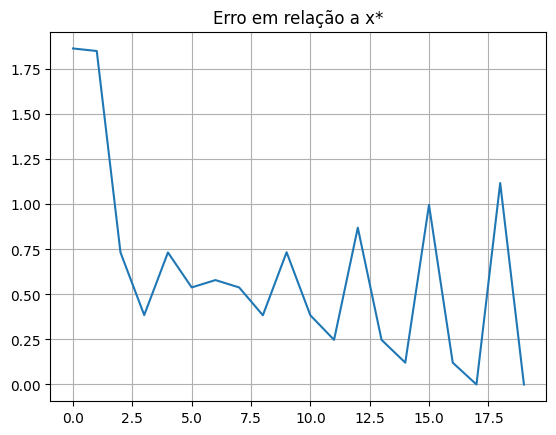

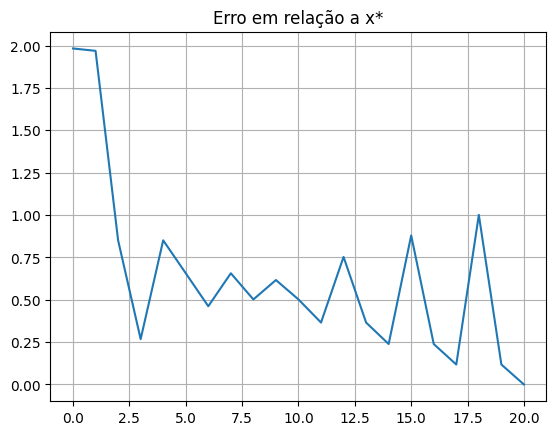

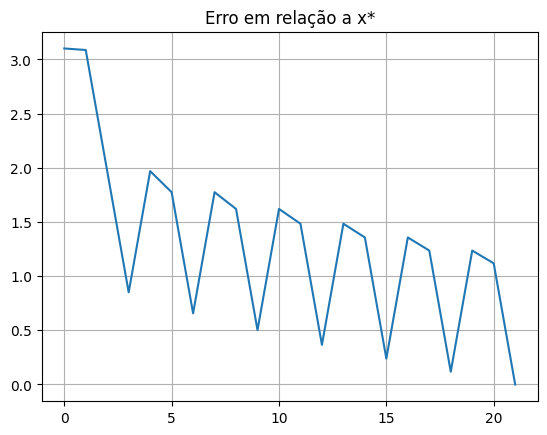

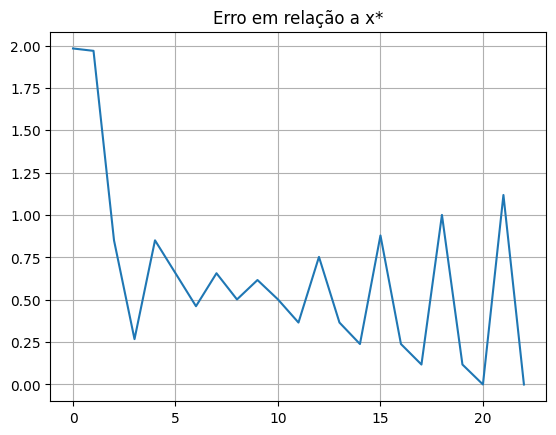

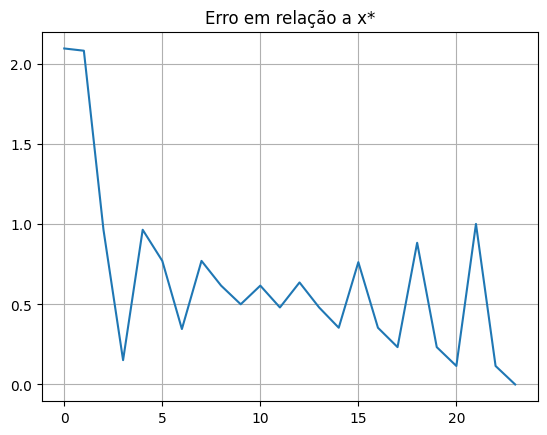

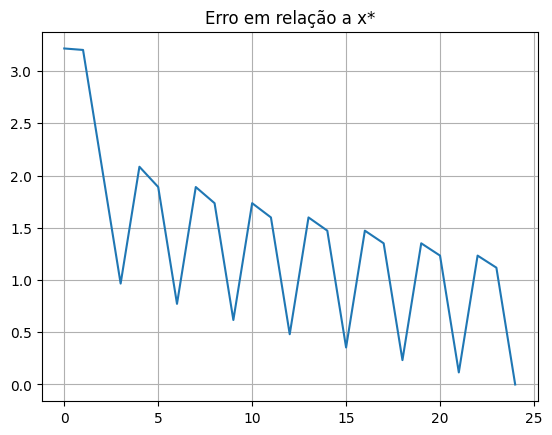

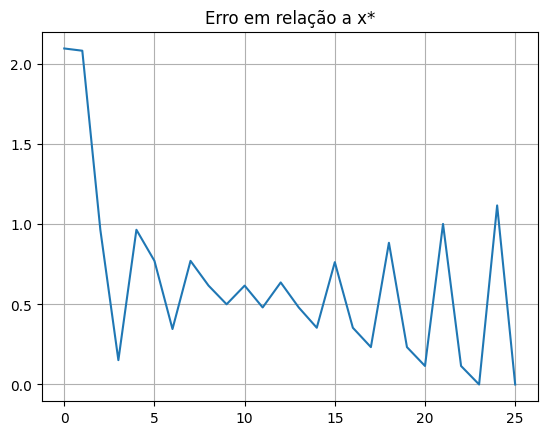

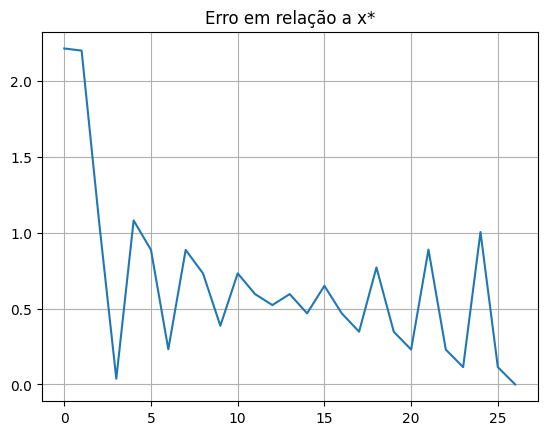

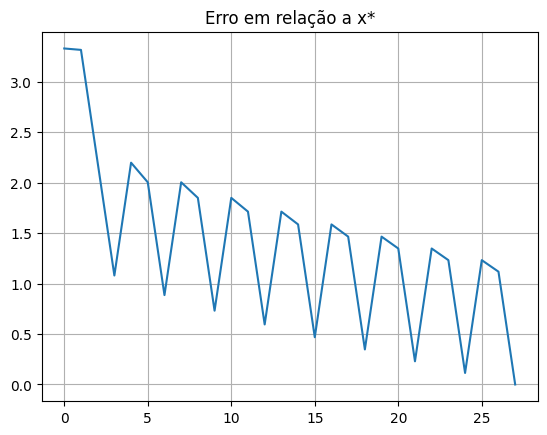

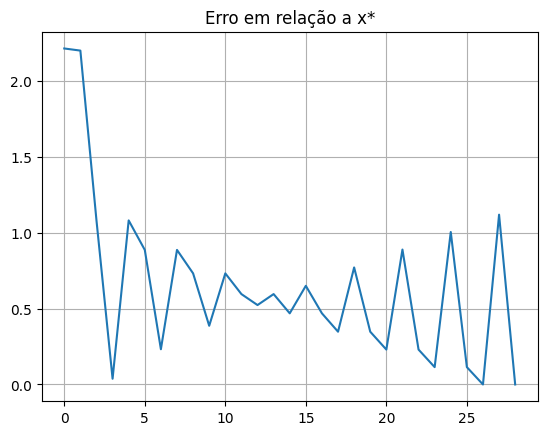

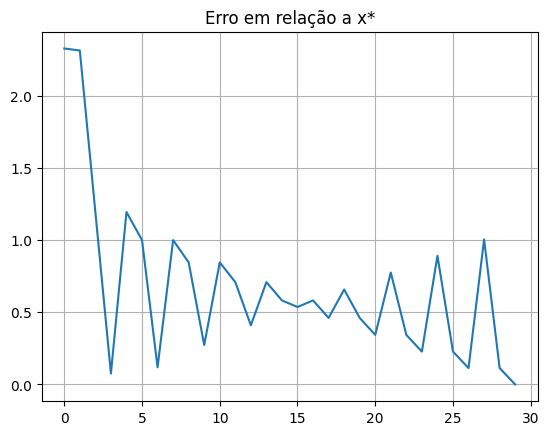

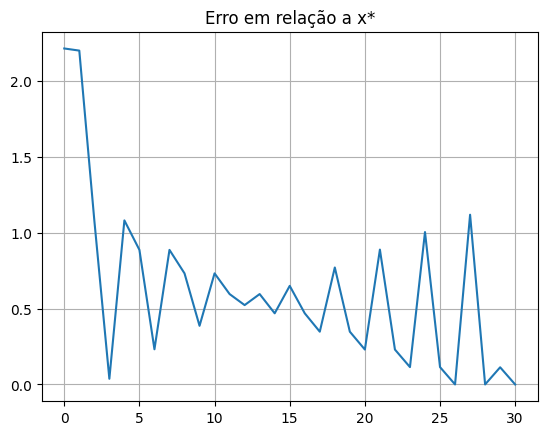

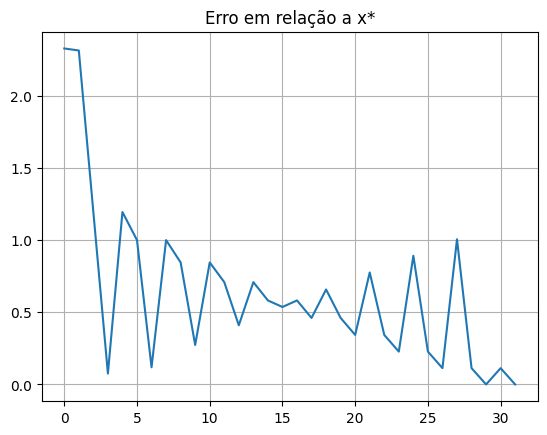

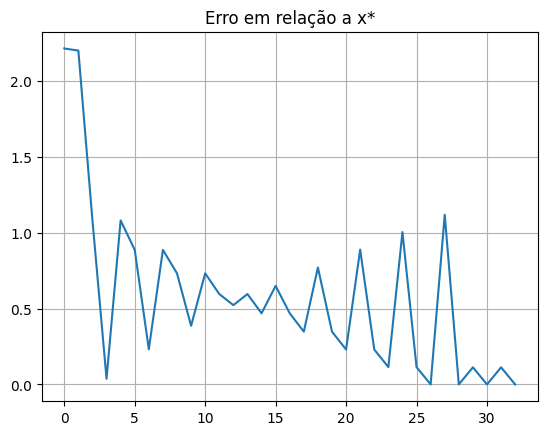

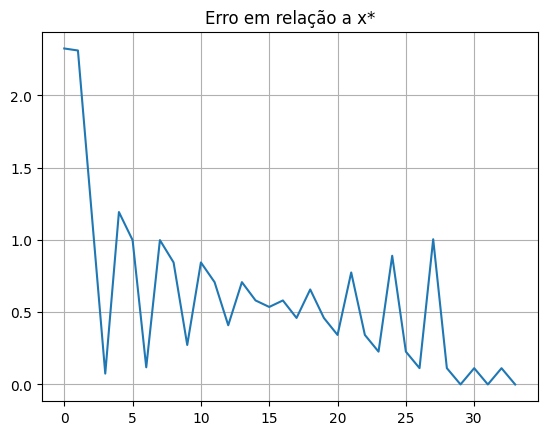

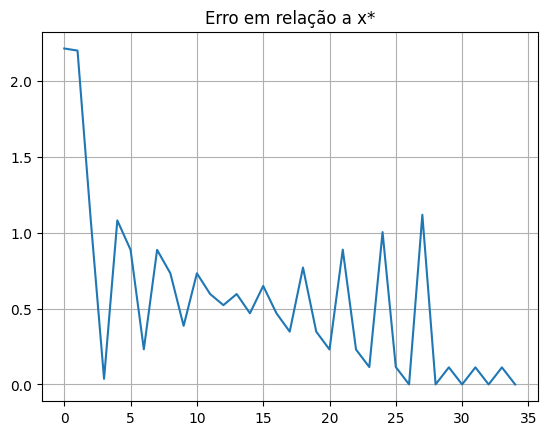

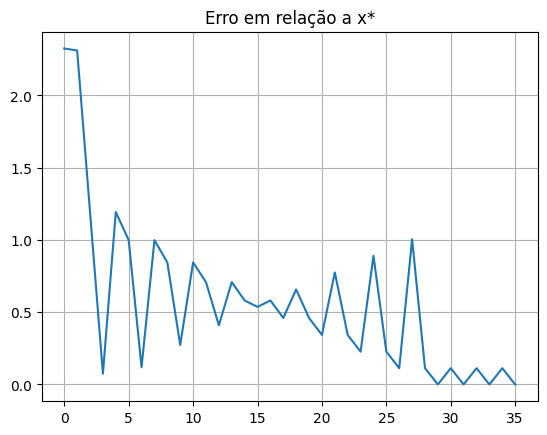

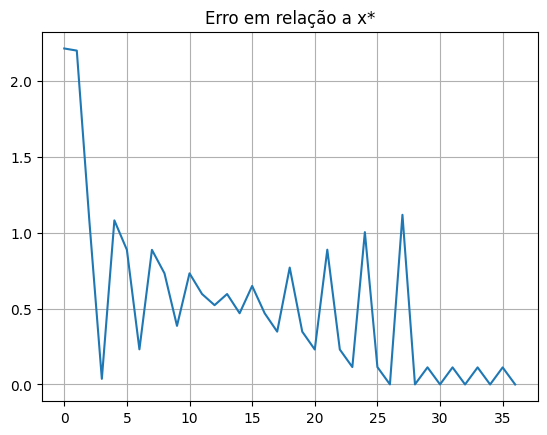

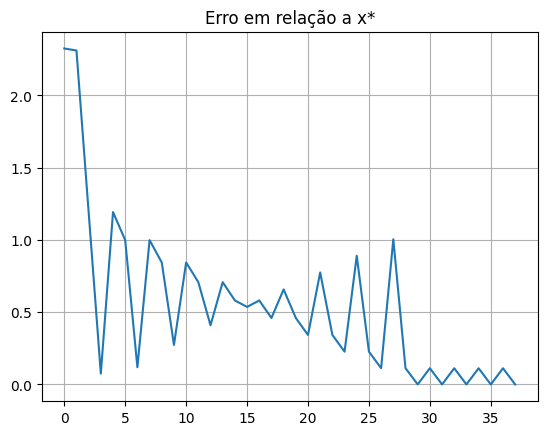

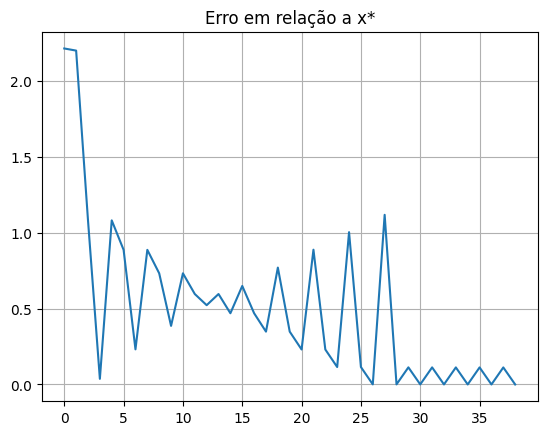

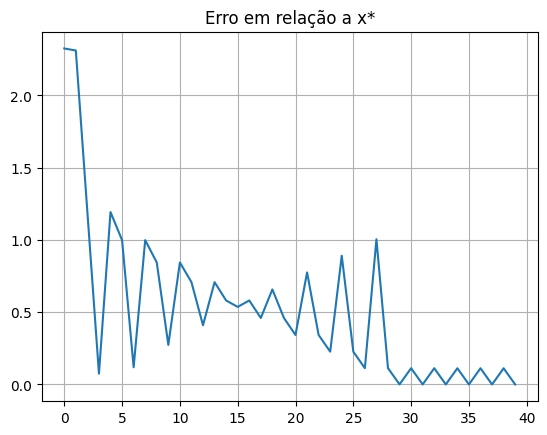

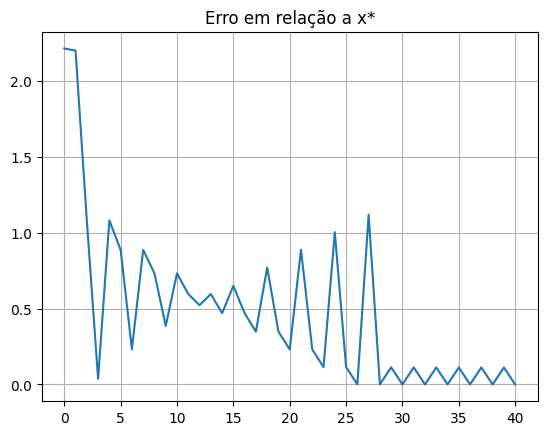

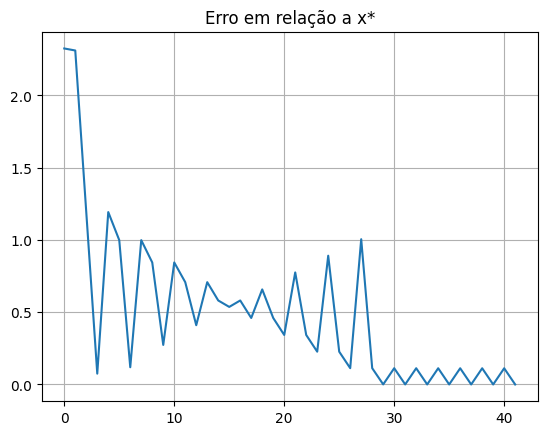

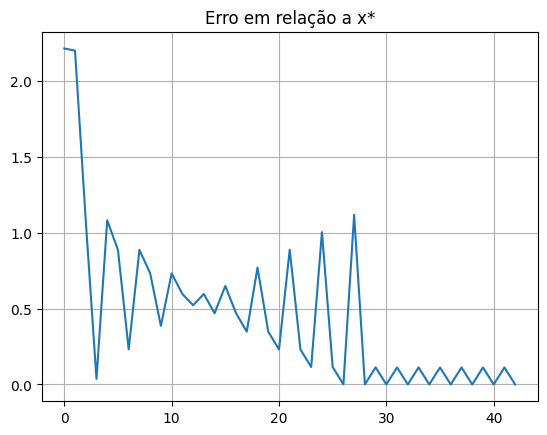

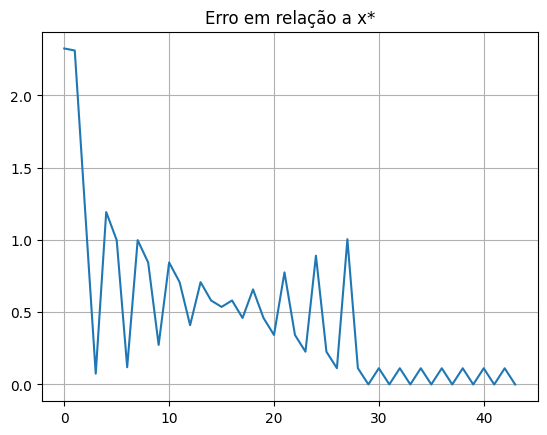

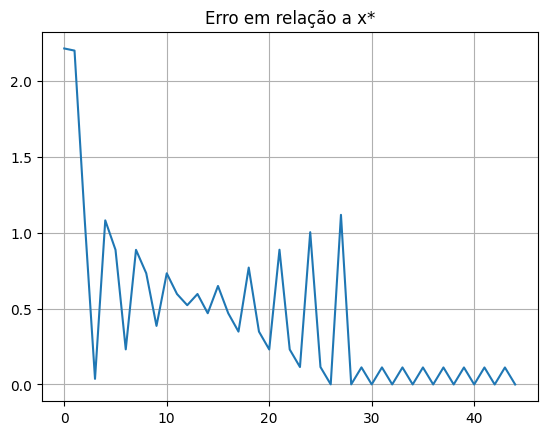

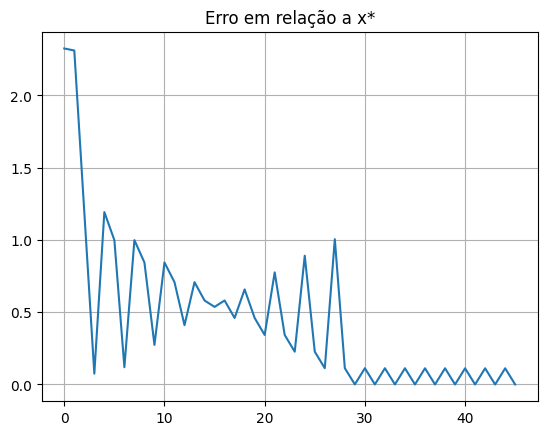

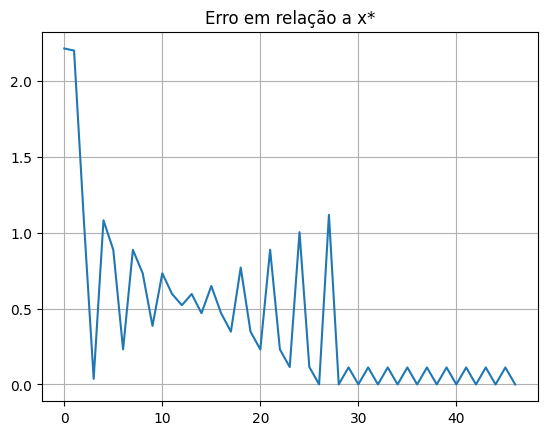

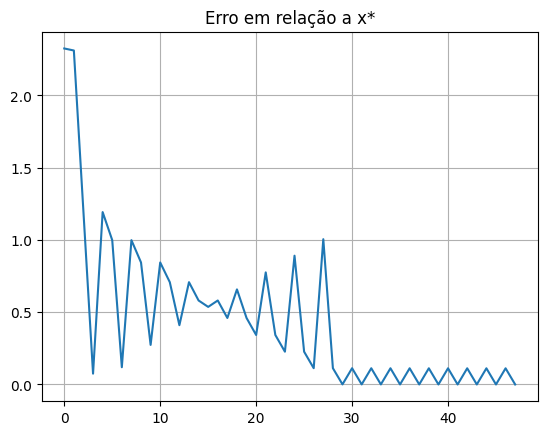

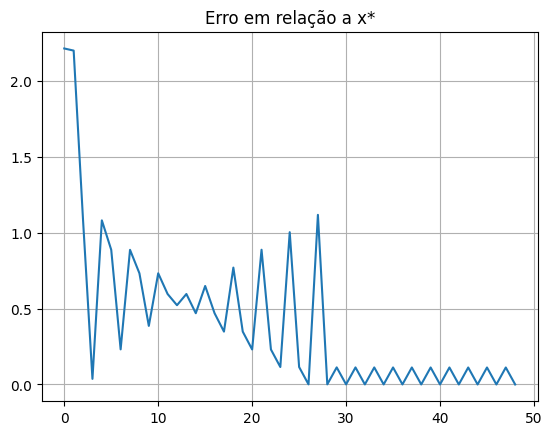

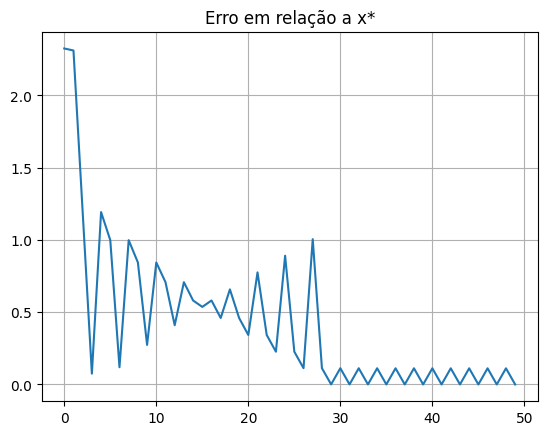

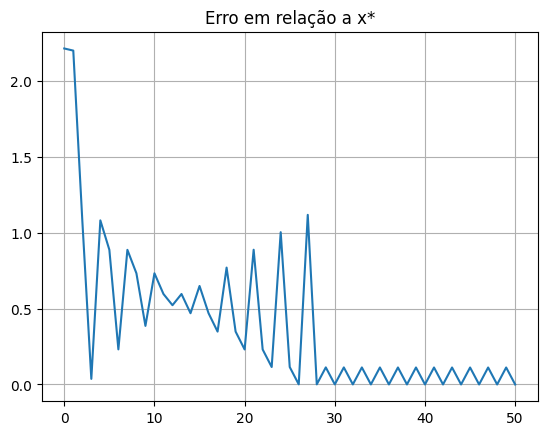

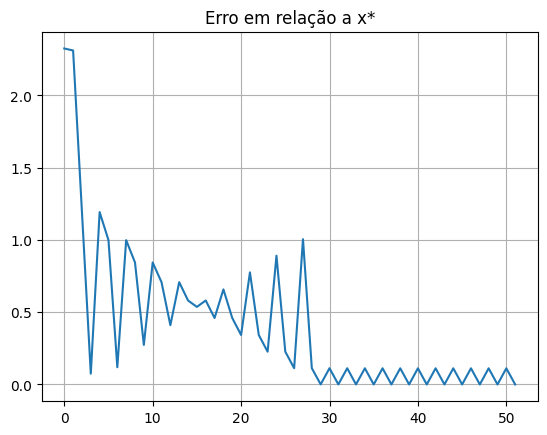

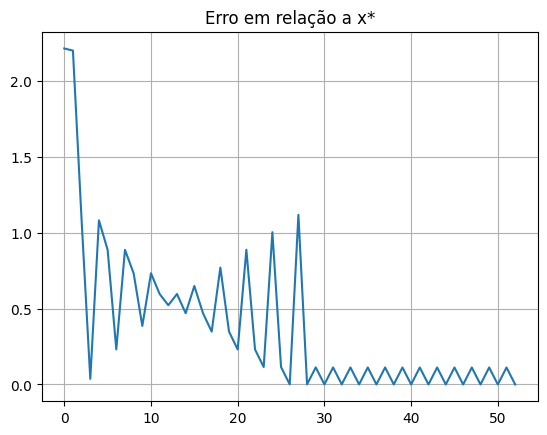

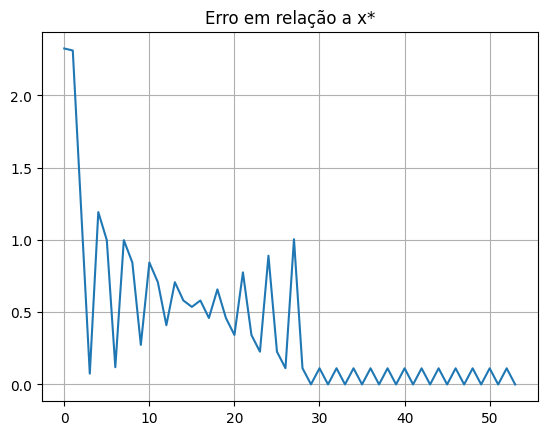

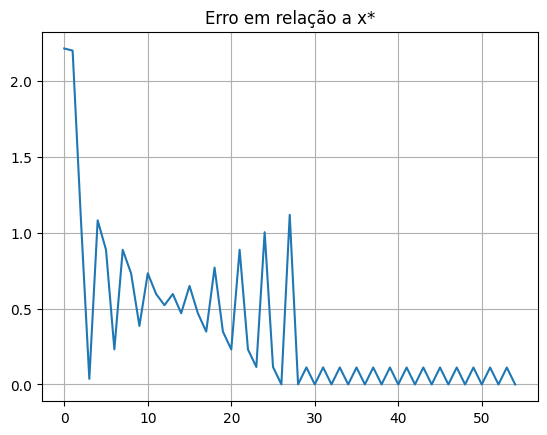

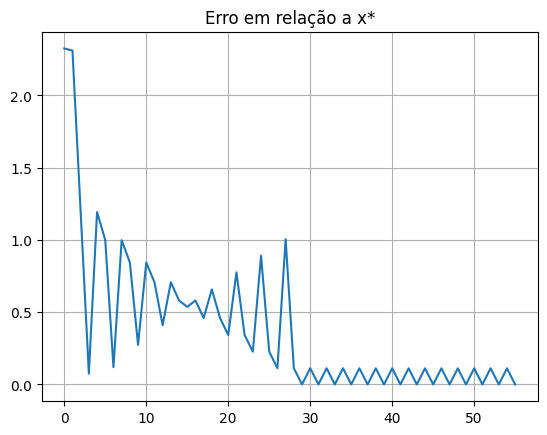

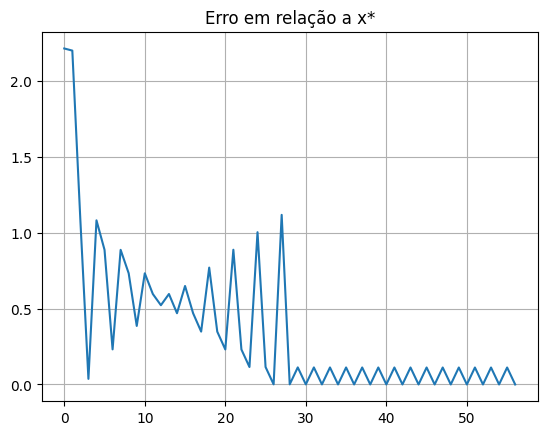

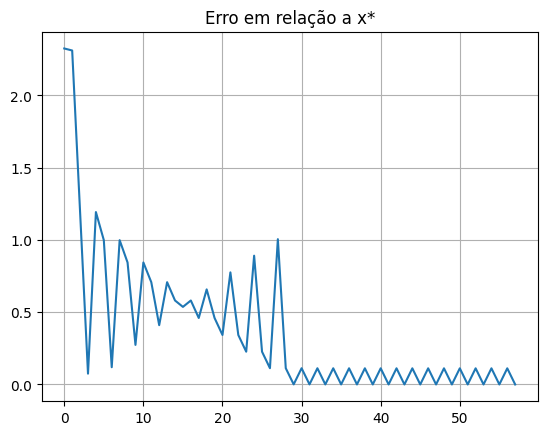

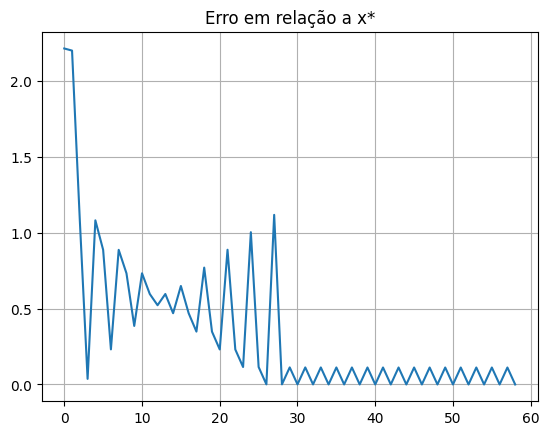

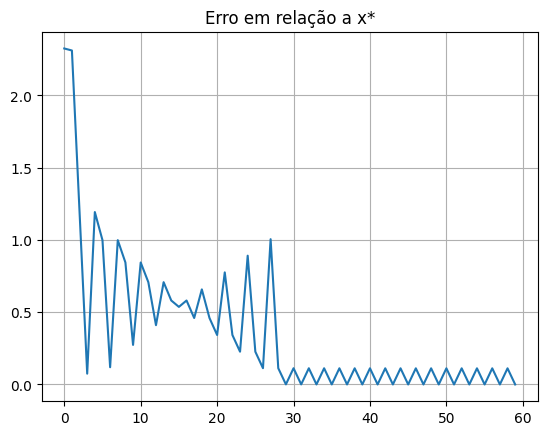

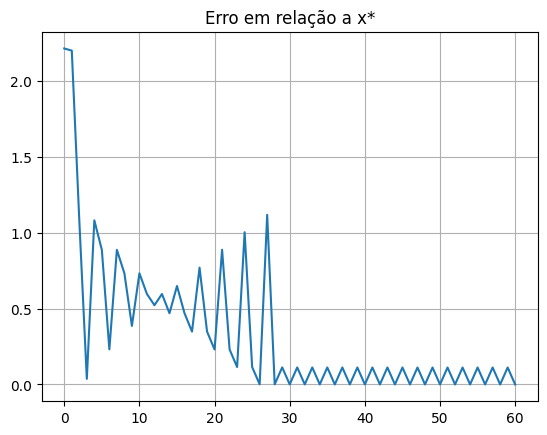

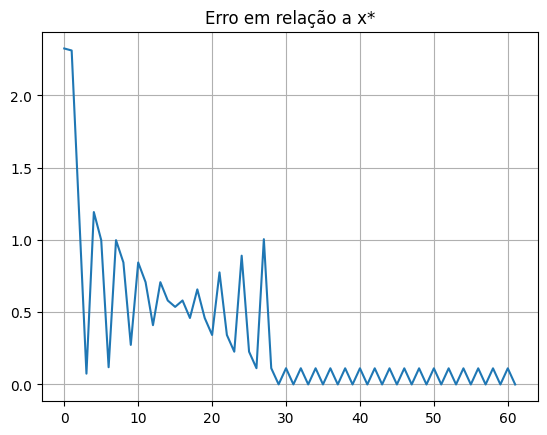

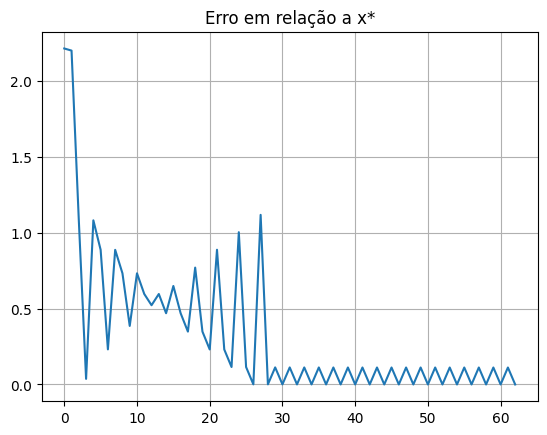

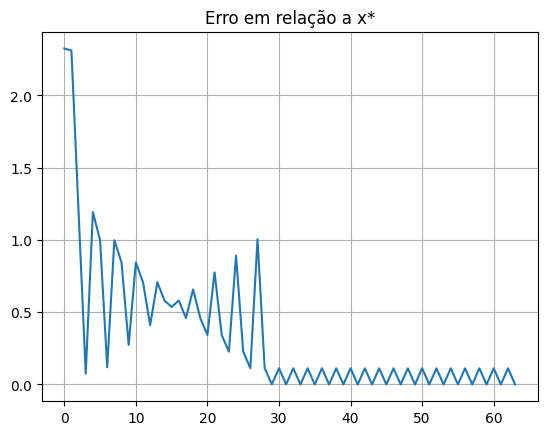

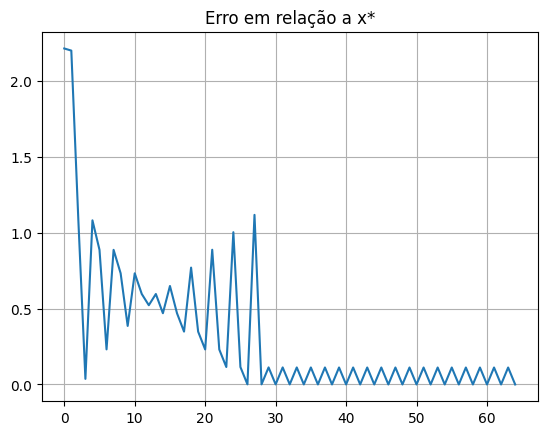

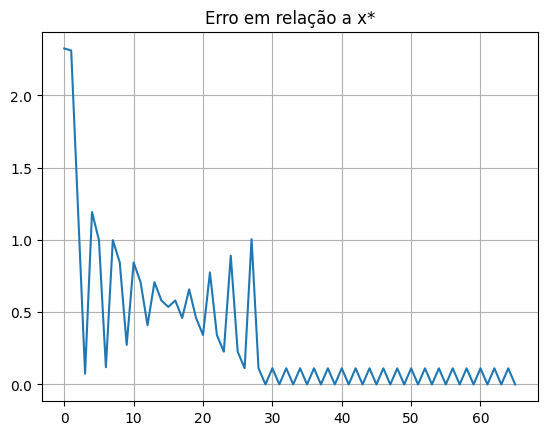

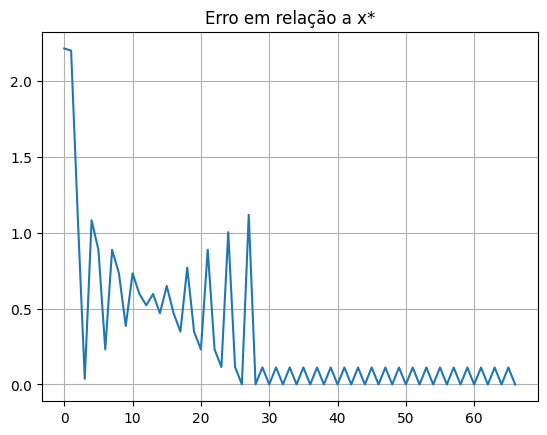

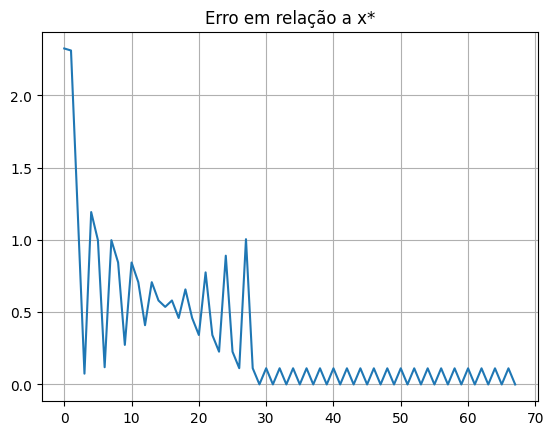

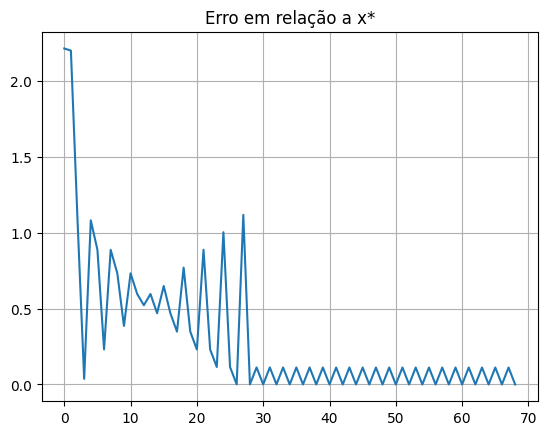

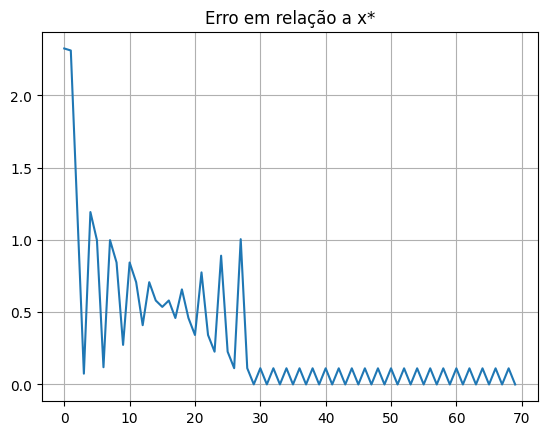

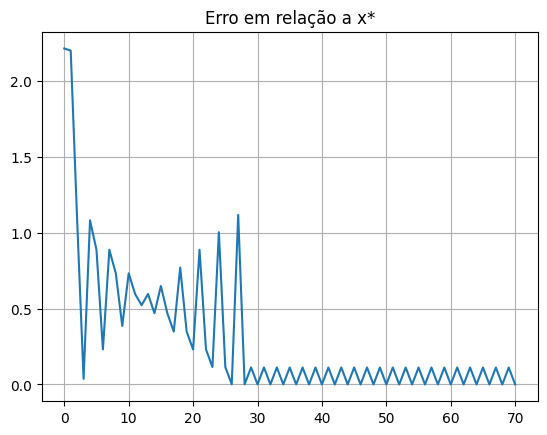

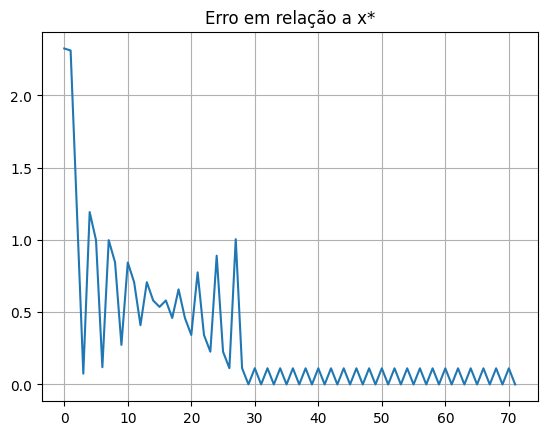

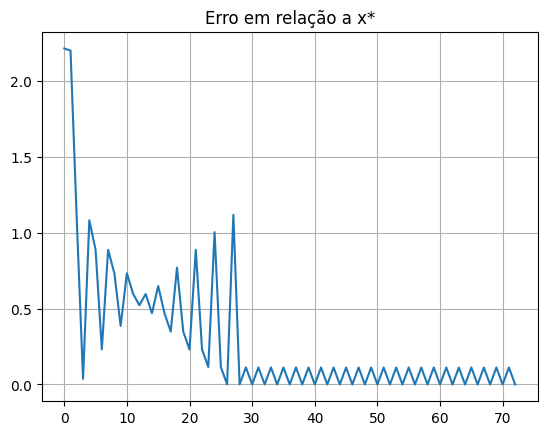

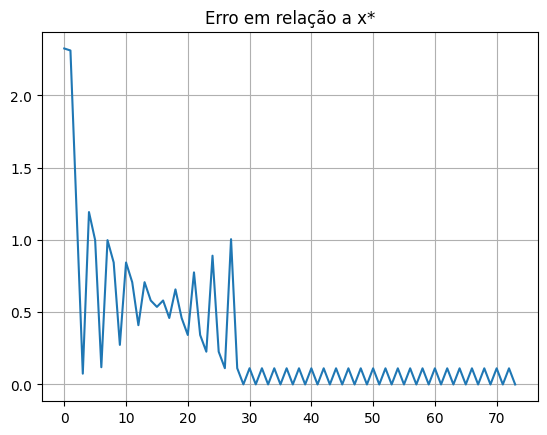

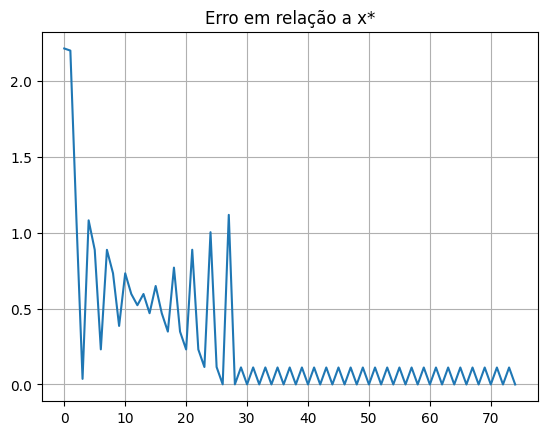

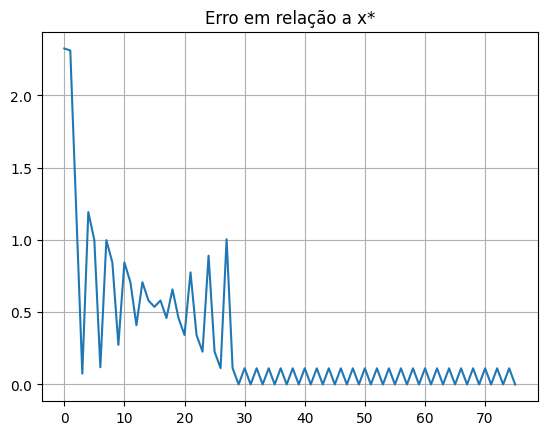

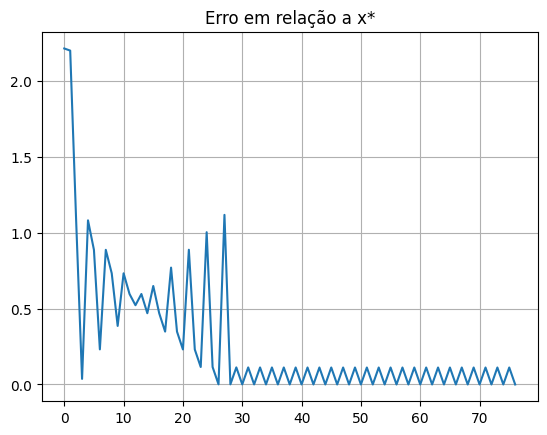

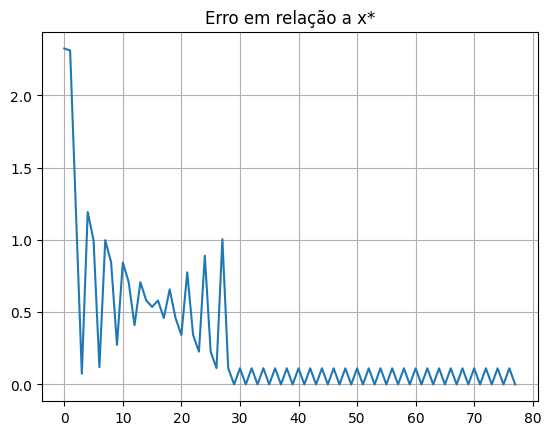

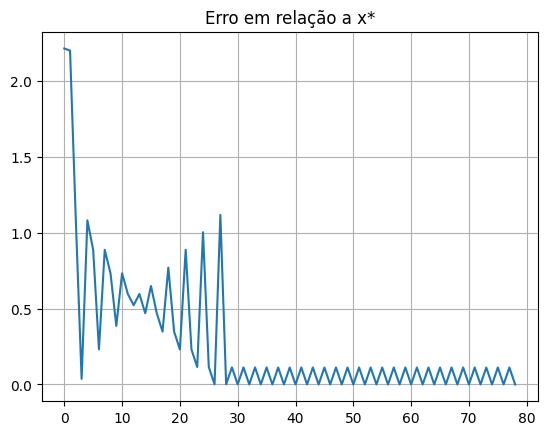

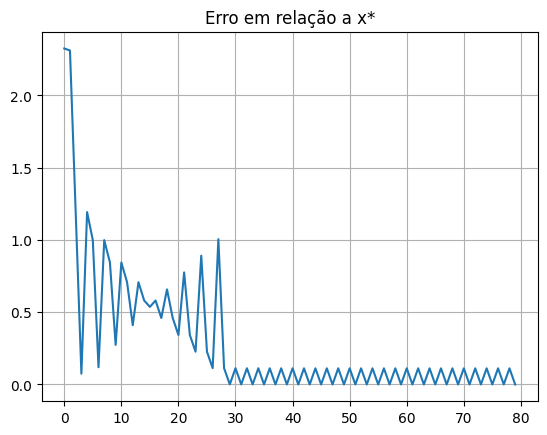

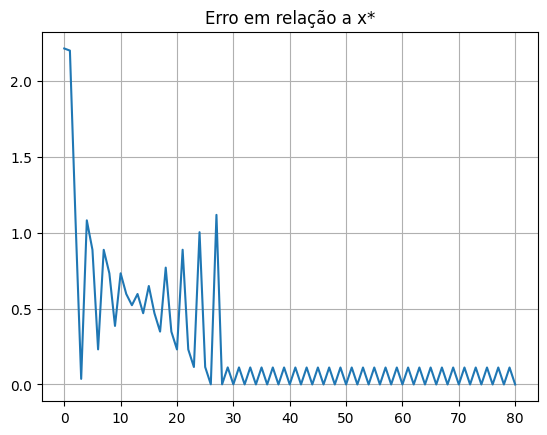

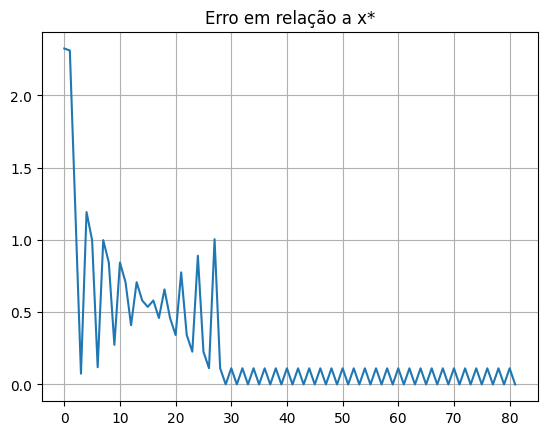

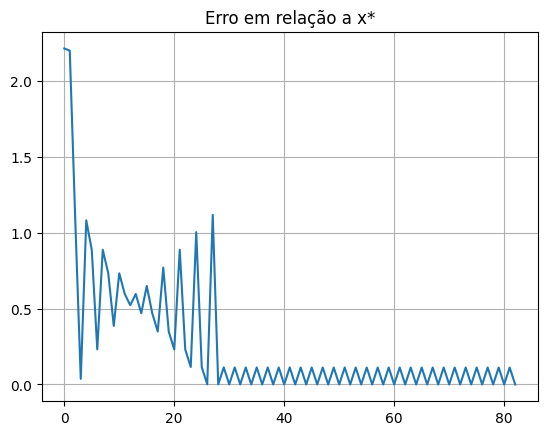

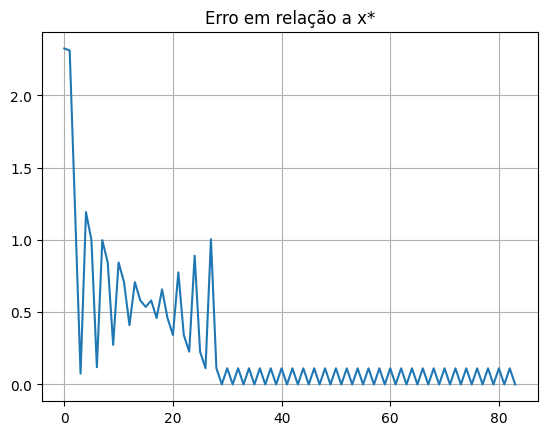

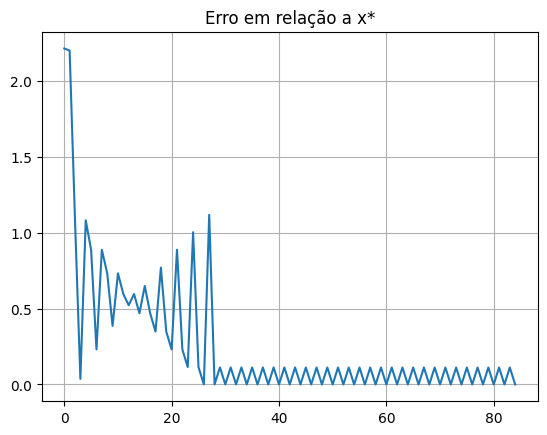

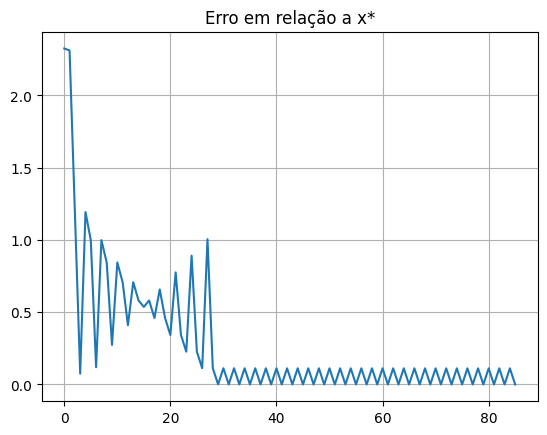

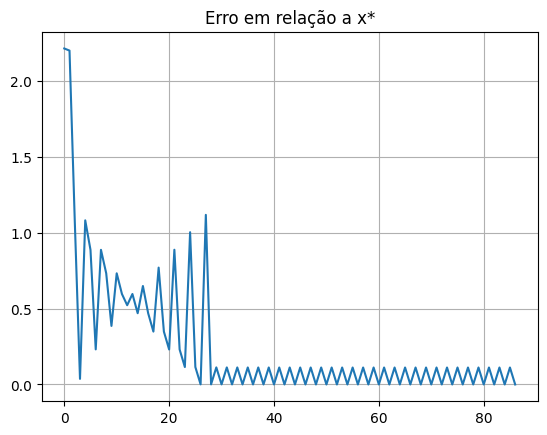

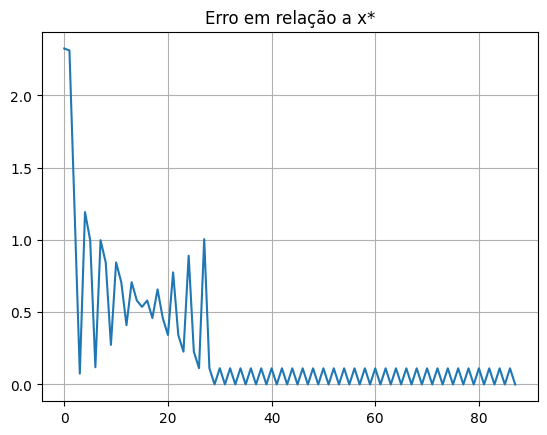

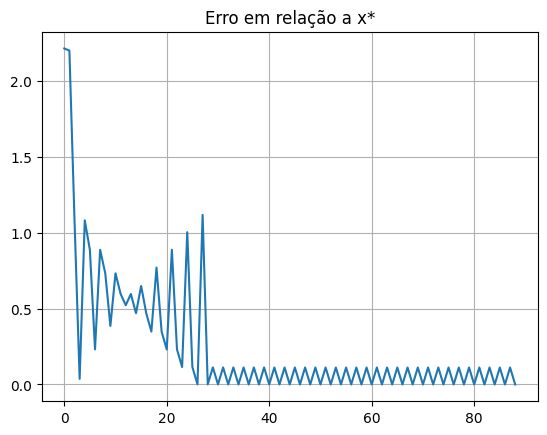

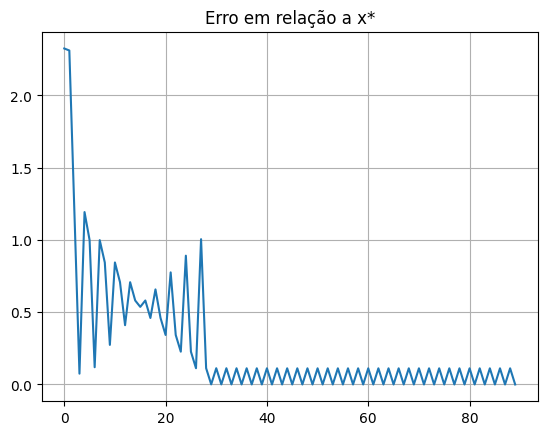

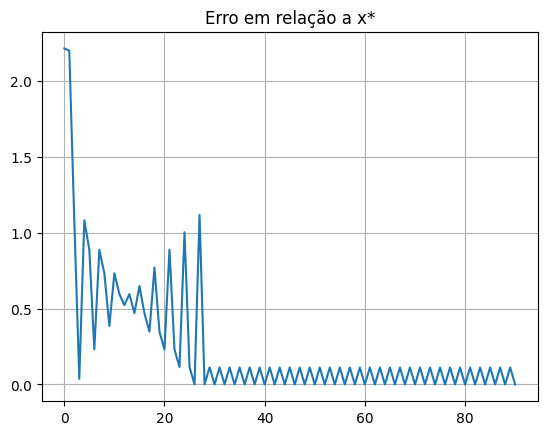

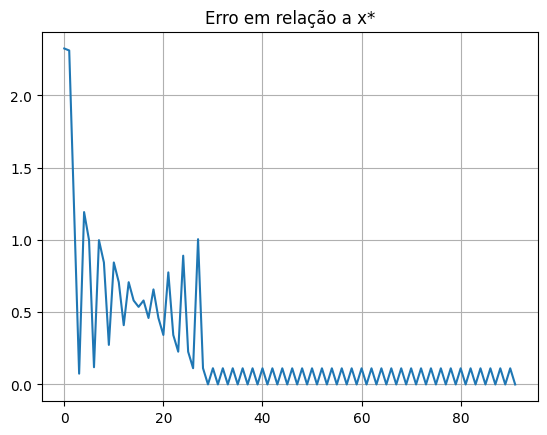

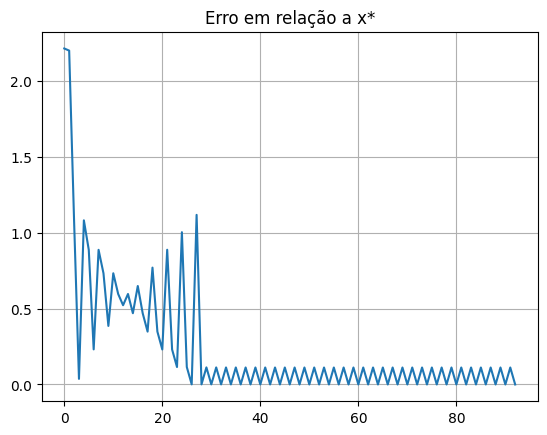

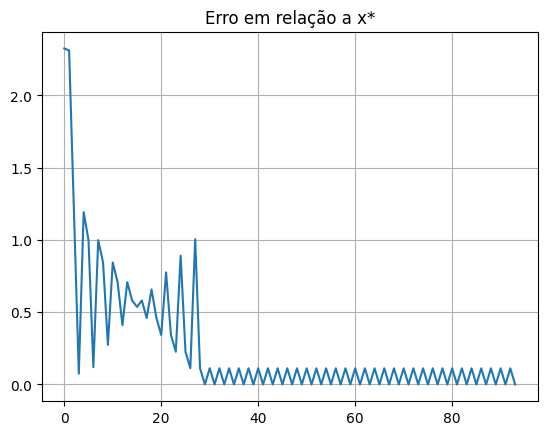

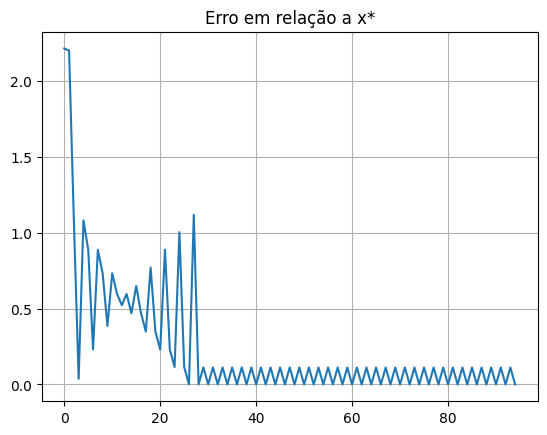

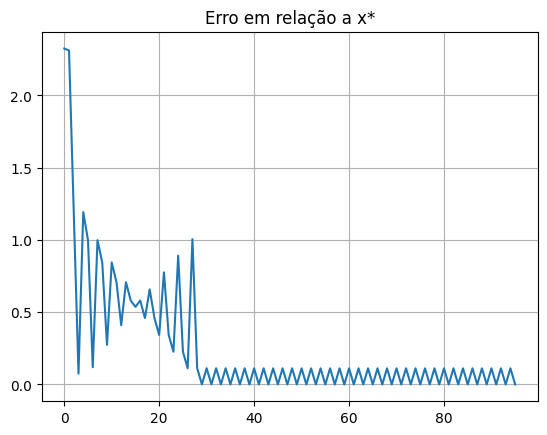

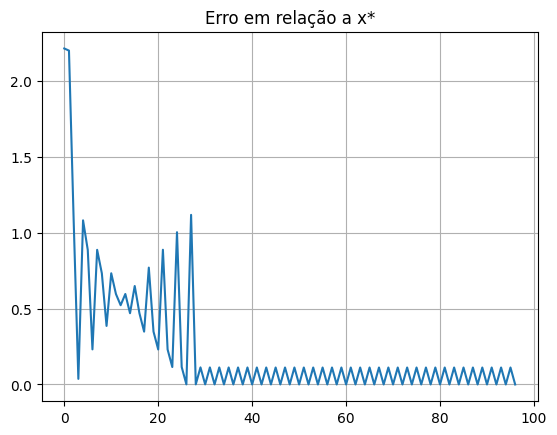

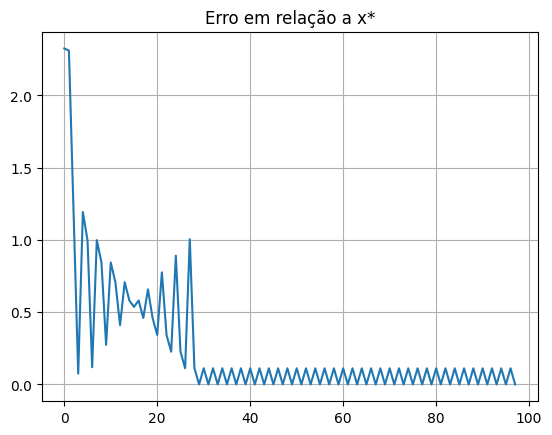

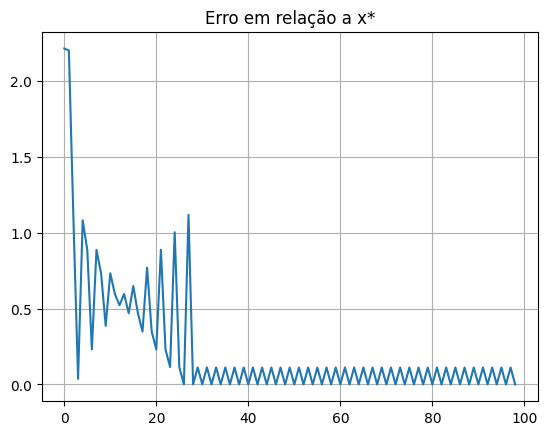

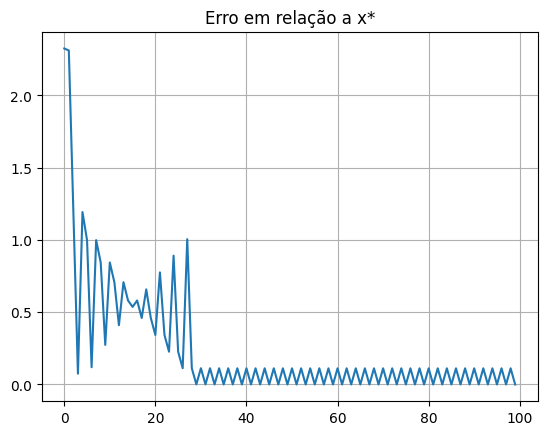

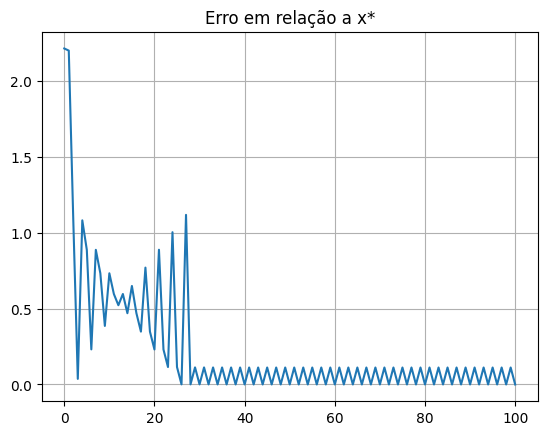

Parada pelo número máximo de iterações.
Ponto ótimo aproximado: [0.98973055 1.97946109]
Valor ótimo da função: 0.007893
Número de iterações: 100
Número de avaliações da função: 100


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Algoritmo Quase-Newton
def otqn_python(funcao, isa_FV, Imetqn, max_iter, x0, Xmin, Xmax, epslon):
    k = 1
    fim = False
    XK = [x0.copy()]
    Hfobj = []
    Hgrad = []
    xkold = None
    gkold = None
    nxk = len(x0)
    Imatqn = np.eye(nxk)
    keps = 1.0e-03
    icfunc = 0
    Hdxk = np.zeros((nxk, 3))
    xk = x0.copy()

    while not fim:
        fobjnew, dfobjnew = funcao(xk)
        icfunc += 1
        Hfobj.append(fobjnew)
        Hgrad.append(dfobjnew.copy())

        if k > 1 and abs(Hfobj[-1] - Hfobj[-2]) < epslon:
            print("Variação da função objetivo nula.")
            break

        if np.linalg.norm(dfobjnew) <= keps * epslon:
            print("Norma do gradiente função objetivo é nula.")
            break

        if k > 1:
            s = xk - xkold
            y = dfobjnew - gkold
            if Imetqn == 0:  # DFP
                rho = 1.0 / (y @ s)
                Hy = Imatqn @ y
                Imatqn -= np.outer(Hy, Hy) / (y @ Hy)
                Imatqn += rho * np.outer(s, s)
            else:
                corr = Imetqn - 1 if Imetqn > 1 else 0
                rho = 1.0 / (y @ s)
                I = np.eye(nxk)
                V = I - rho * np.outer(s, y)
                Imatqn = V @ Imatqn @ V.T + rho * np.outer(s, s)
                if corr == 1:  # Huang
                    tet = 6 * (fobjold - fobjnew) + 3 * (gkold + dfobjnew) @ s
                    y = (1 + tet / (s @ y)) * y
                elif corr == 2:  # Biggs
                    eps_b = (fobjnew - fobjold) / (s @ gkold)
                    beta = s @ dfobjnew / (s @ gkold)
                    if abs(2 * beta + 1 - 3 * eps_b) > epslon:
                        eta = 0.5 * (beta - 1) / (2 * beta + 1 - 3 * eps_b)
                        y = gkold + eta * (dfobjnew - gkold)
        else:
            Imatqn = np.eye(nxk)

        dxk = -Imatqn @ dfobjnew
        mdxk = np.max(np.abs(dxk))
        if mdxk <= keps * epslon:
            print("Módulo da direção de busca é nulo.")
            break
        dxk /= mdxk

        if k > 1:
            alfaotim = 1.0
        else:
            dot = dfobjnew @ dfobjnew
            alfaotim = abs(0.05 * fobjnew / dot) if dot > 1e-3 * epslon else 0.025

        for i in range(nxk):
            Hdxk[i, 0] = Hdxk[i, 1]
            Hdxk[i, 1] = Hdxk[i, 2]
            Hdxk[i, 2] = dxk[i]
        ss = np.sign(Hdxk)
        oscilacao = any(ss[i, 2] != ss[i, 1] and ss[i, 2] == ss[i, 0] for i in range(nxk))
        if oscilacao:
            fator = 10 * (1 - np.exp(-(k + 1) / 7))
            alfaotim /= fator

        xkold = xk.copy()
        xk = xk + alfaotim * dxk
        xk = np.minimum(np.maximum(xk, Xmin), Xmax)
        xknew = xk.copy()
        XK.append(xk)

        if np.linalg.norm(xknew - xkold) <= epslon:
            print("Delta x nulo.")
            break

        erxk = np.array(XK).T - xk.reshape(-1, 1)
        plt.figure(10)
        plt.clf()
        plt.plot(np.sqrt(np.sum(erxk**2, axis=0)))
        plt.title("Erro em relação a x*")
        plt.grid(True)
        plt.pause(0.1)

        fobjold = fobjnew
        gkold = dfobjnew.copy()

        if k >= max_iter:
            fim = True
            print("Parada pelo número máximo de iterações.")
        else:
            k += 1

    return np.array(XK).T, np.array(Hfobj), k, icfunc

# Função de teste quadrática
def f_quadratica(x):
    f = (x[0] - 1)**2 + (x[1] - 2)**2
    grad = np.array([2*(x[0] - 1), 2*(x[1] - 2)])
    return f, grad

# Parâmetros
x0 = np.array([0.0, 0.0])
Xmin = np.array([-5.0, -5.0])
Xmax = np.array([5.0, 5.0])
epslon = 1e-6
max_iter = 100
isa_FV = 0
Imetqn = 1  # BFGS

# Execução
XK, Hfobj, k_final, icfunc = otqn_python(
    funcao=f_quadratica,
    isa_FV=isa_FV,
    Imetqn=Imetqn,
    max_iter=max_iter,
    x0=x0,
    Xmin=Xmin,
    Xmax=Xmax,
    epslon=epslon
)

# Resultados
print(f"Ponto ótimo aproximado: {XK[:,-1]}")
print(f"Valor ótimo da função: {Hfobj[-1]:.6f}")
print(f"Número de iterações: {k_final}")
print(f"Número de avaliações da função: {icfunc}")

In [2]:
import numpy as np
from scipy.optimize import minimize

# Função a ser minimizada
def f(x, a):
    x1, x2 = x
    return 12*x1**2 + 4*x2**2 - 12*x1*x2 + 2*x1 + a*(x1**3 + x2**3)

# Gradiente da função
def grad_f(x, a):
    x1, x2 = x
    df_dx1 = 24*x1 - 12*x2 + 2 + 3*a*x1**2
    df_dx2 = 8*x2 - 12*x1 + 3*a*x2**2
    return np.array([df_dx1, df_dx2])

# Matriz Hessiana
def hessian(x, a):
    x1, x2 = x
    H11 = 24 + 6*a*x1
    H12 = -12
    H21 = -12
    H22 = 8 + 6*a*x2
    return np.array([[H11, H12], [H21, H22]])

# Verificação de convexidade
def is_convex(x, a):
    H = hessian(x, a)
    det = H[0,0]*H[1,1] - H[0,1]*H[1,0]
    return det >= 0

# Solução para a = 0
a = 0
x0 = np.array([0, 0])  # Chute inicial
res = minimize(lambda x: f(x, a), x0, jac=lambda x: grad_f(x, a), method='BFGS')
print(f"Solução para a = {a}: x1 = {res.x[0]:.4f}, x2 = {res.x[1]:.4f}")

# Solução para a ≠ 0 (exemplo: a = 1)
a = 1
res = minimize(lambda x: f(x, a), x0, jac=lambda x: grad_f(x, a), method='BFGS')
print(f"Solução para a = {a}: x1 = {res.x[0]:.4f}, x2 = {res.x[1]:.4f}")
print(f"Convexidade em x = {res.x}: {is_convex(res.x, a)}")

# Determinar intervalo de a para convexidade
def find_a_limits(x_test):
    a_poly = [36*x_test[0]*x_test[1], 144*x_test[1] + 48*x_test[0], 48]
    roots = np.roots(a_poly)
    return roots

x_test = np.array([10, 10])
a_roots_sup = find_a_limits(x_test)
a_sup = max(a_roots_sup)

x_test = np.array([-10, -10])
a_roots_inf = find_a_limits(x_test)
a_inf = min(a_roots_inf)

print(f"Intervalo de a para convexidade: a ∈ [{a_inf:.4f}, {a_sup:.4f}]")

Solução para a = 0: x1 = -0.3333, x2 = -0.5000
Solução para a = 1: x1 = -201.3545, x2 = -387.7727
Convexidade em x = [-201.35452345 -387.772744  ]: True
Intervalo de a para convexidade: a ∈ [0.0263, -0.0263]


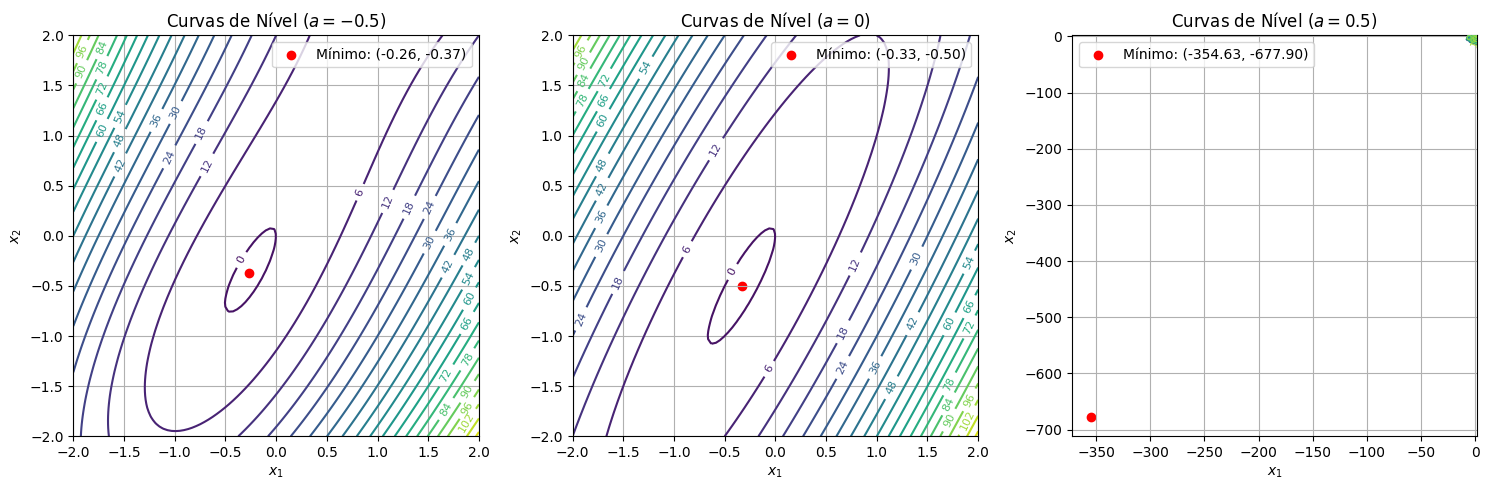

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Função a ser plotada
def f(x1, x2, a):
    return 12*x1**2 + 4*x2**2 - 12*x1*x2 + 2*x1 + a*(x1**3 + x2**3)

# Configuração do grid
x1 = np.linspace(-2, 2, 100)
x2 = np.linspace(-2, 2, 100)
X1, X2 = np.meshgrid(x1, x2)

# Valores de 'a' a serem plotados
a_values = [-0.5, 0, 0.5]

# Plotagem
plt.figure(figsize=(15, 5))
for i, a in enumerate(a_values):
    Z = f(X1, X2, a)

    # Subplot 1: Curvas de nível
    plt.subplot(1, 3, i+1)
    contour = plt.contour(X1, X2, Z, levels=20, cmap='viridis')
    plt.clabel(contour, inline=True, fontsize=8)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(f'Curvas de Nível ($a = {a}$)')
    plt.grid(True)

    # Ponto de mínimo (calculado previamente)
    if a == 0:
        x1_min, x2_min = -1/3, -1/2
    else:
        from scipy.optimize import minimize
        res = minimize(lambda x: f(x[0], x[1], a), x0=[0, 0], method='BFGS')
        x1_min, x2_min = res.x
    plt.scatter(x1_min, x2_min, color='red', label=f'Mínimo: ({x1_min:.2f}, {x2_min:.2f})')
    plt.legend()

plt.tight_layout()
plt.savefig('grafico.png', dpi=300, bbox_inches='tight')
plt.show()